# Results Analysis

In [3]:
library(arrow)
library(lubridate)
library(data.table)
library(ggplot2)
library(stringr)
library(aricode)
library(plyr)
library(dplyr)
library(bit64)
library(scales)
library(Matrix)
library(tidytext)
library(vsp)
library(tidyr)
library(paletteer)
library(Hmisc)
library(binom)
library(patchwork)
theme_set(theme_bw(20))
options(arrow.skip_nul = TRUE)

In [2]:
load("data/rtnet_clustering.rdata")
load("data/rt_tweet_clustering.rdata")

# Plot Figure 1

In [5]:
daily_counts <- fread("data/tweet_counts.csv")

In [6]:
options(repr.plot.width = 12, repr.plot.height = 5)

dc = daily_counts[,sum(count), by=date]
dc[, dt := ymd(date)]
data_plt <- ggplot(dc[dt > ymd("2020-01-26") & dt < ymd("2020-12-27")], 
                   aes(dt, V1))+geom_point() + 
stat_smooth(method="gam") + 
geom_vline(aes(xintercept = ymd("2020-03-03"),color='orange'),linewidth=1.2) + 
geom_vline(aes(xintercept = ymd("2020-08-16"),color='purple'), linewidth=1.2)  +
geom_vline(aes(xintercept = ymd("2020-11-03"),color='green'), linewidth=1.2)  +
scale_y_continuous("Daily Number of Tweets",labels=comma)+
xlab("Date") +
scale_color_discrete("Critical Dates",labels=c("Super Tuesday",
                                              "Start of DNC\nConvention",
                                              "Election Day"))+
theme(legend.spacing.y=unit(.5,"cm")) +
  guides(color = guide_legend(byrow = TRUE))


`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


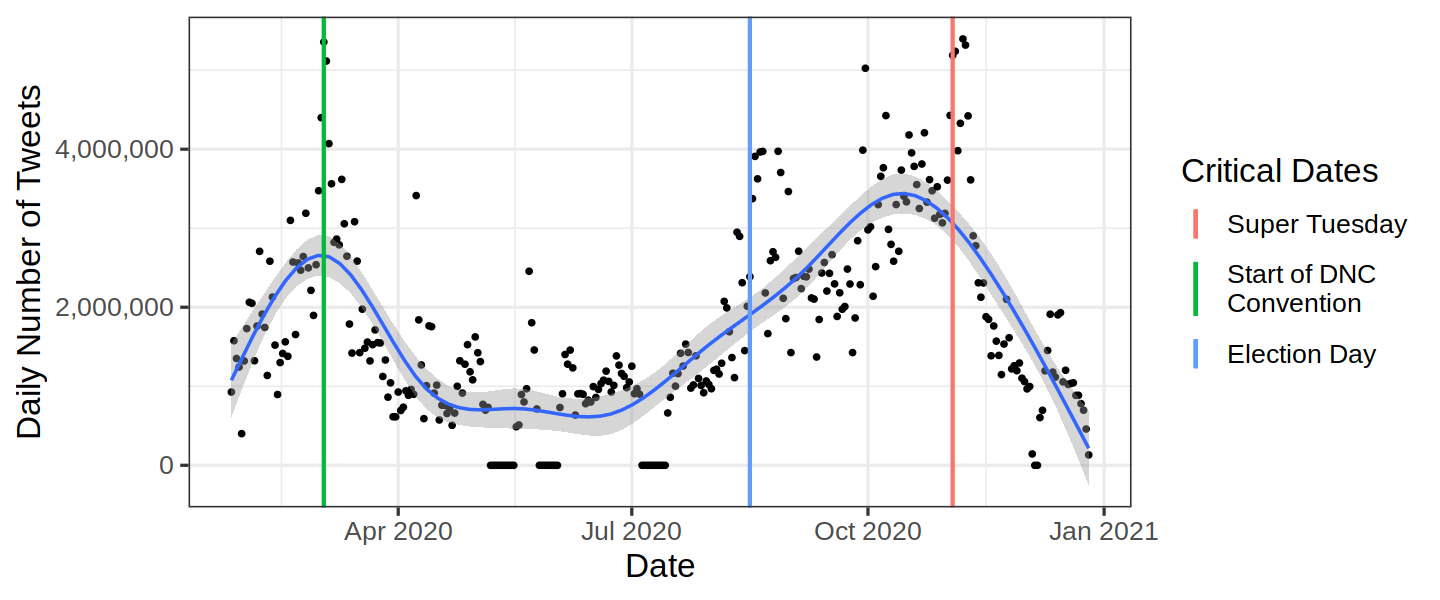

In [7]:
data_plt

In [48]:
ggsave("plots/fig1.pdf", data_plt, h=5,w=12)

`geom_smooth()` using formula = 'y ~ s(x, bs = "cs")'


## Main Results, Part 1: Evaluating Who RTs Whom Clustering

In [8]:
# How many Bernie supporters per cluster?
reslist[[35]]$zmg[grp %in% c(3,5,11,19,27),.N, by=grp]

grp,N
<int>,<int>
27,71778
11,51685
3,6114
19,30170
5,77730


## Evaluate based on who retweeted Bernie

In [28]:
library(tidylo)

rt_data <- rbindlist(lapply(Sys.glob("data/rtnet_eval/part-*.parquet"),read_parquet))


In [29]:
rt_data <- merge(rt_data, reslist[[35]]$zmg[,.(uid,grp)])

In [55]:
rt_data[,.N, by=.(sn)]

sn,N
<chr>,<int>
JoeBiden,600130
TulsiGabbard,110381
ewarren,266726
AndrewYang,243974
PeteButtigieg,212544
amyklobuchar,140525
Mike2020,17896
BernieSanders,526600
TrumpWarRoom,258095


In [31]:
rtagg <- rt_data[,.N, by=.(grp,sn)]
rtagg <- data.table(complete(data.frame(rtagg), grp, sn, fill = list(N= 0)))
rtagg <- bind_log_odds(rtagg,grp,sn,N)


In [32]:
m <- rtagg[order(-log_odds_weighted)][,.SD[1], by=grp]
h <- merge(m[,.(grp,log_odds_weighted)],
      rtagg[sn =="BernieSanders",.(grp,log_odds_weighted)],by="grp")
h <- merge(h, reslist[[35]]$zmg[,.N, by=grp],by="grp")

Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


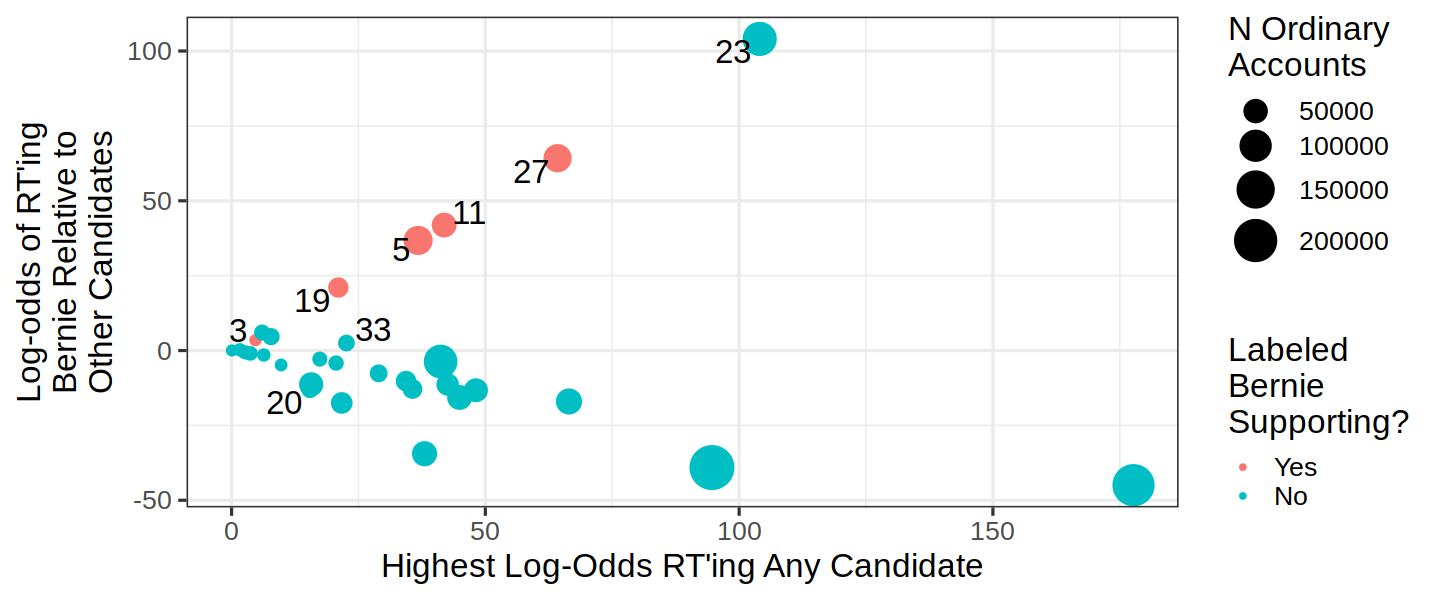

In [33]:
options(repr.plot.width = 12, repr.plot.height = 5)

library(ggrepel)
p <- ggplot(h, aes(log_odds_weighted.x,log_odds_weighted.y,
             label=ifelse(grp %in% c(3,5,11,19,27,23,20,33),grp,"")))+
    geom_point(aes(size=N, color=!(grp %in% c(3,5,11,19,27))))+ 
    geom_text_repel(size=7) + 
    scale_color_discrete("Labeled\nBernie\nSupporting?", 
                         labels=c("Yes","No")) +
    scale_size_continuous("N Ordinary\nAccounts",range=c(1,12)) + 
    xlab("Highest Log-Odds RT'ing Any Candidate")+
    ylab("Log-odds of RT'ing\nBernie Relative to\nOther Candidates") 
p
ggsave("plots/fig2.jpg",p, dpi=400,w=12,h=5)

### Based on Profile Descriptions

In [9]:
# get summary tables
SANDERS_REGEX = "bern|sanders|notmeus|chapo|socialis|🌹|antifa|m4a|medicar"
ym_dat <- reslist[[35]]$ymg[, as.list(binom.agresti.coull(sum(grepl(SANDERS_REGEX, description, ignore.case = T)),.N)),by=grp]
zm_dat <- reslist[[35]]$zmg[, as.list(binom.agresti.coull(sum(grepl(SANDERS_REGEX, description, ignore.case = T)),.N)),by=grp]
ym_dat$utype <- "Influencer"
zm_dat$utype <- "Ordinary"
dat <- rbind(ym_dat,zm_dat)


In [10]:
dat[, grp := factor(grp, levels=dat[,sum(mean),by=grp][order(-V1)]$grp)]

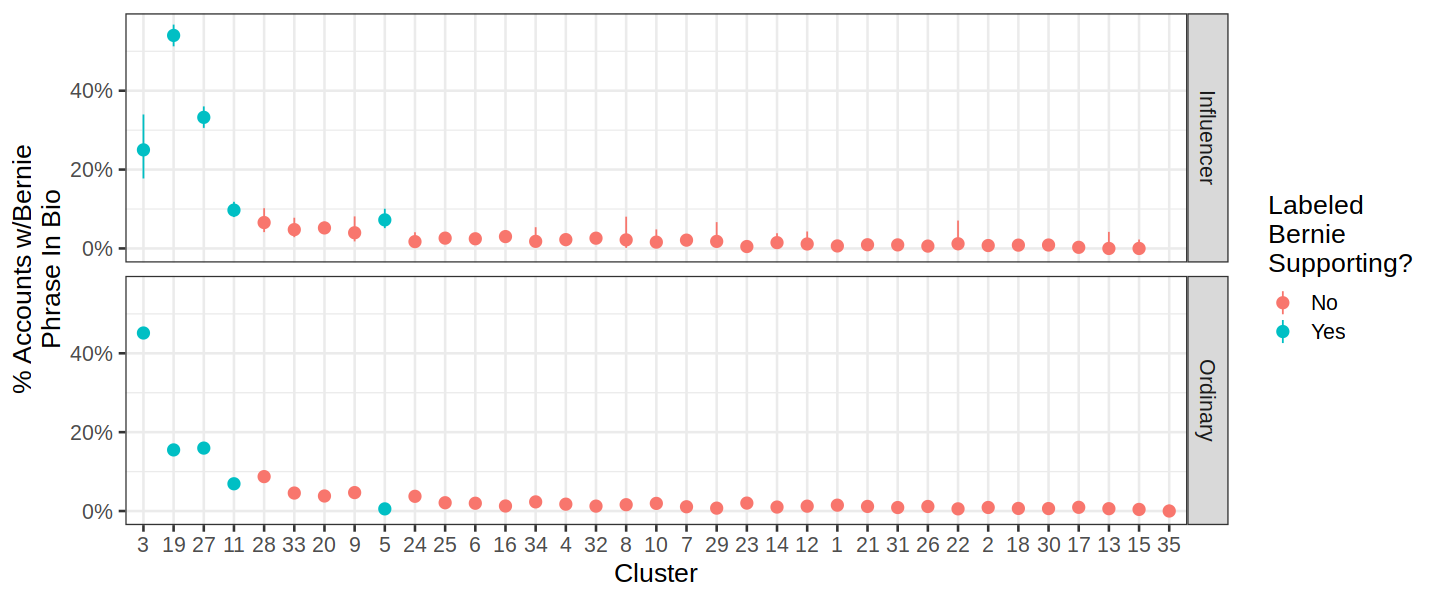

In [11]:
options(repr.plot.width = 12, repr.plot.height = 5)

p2 <- ggplot(dat, aes(grp, mean,ymin=lower,ymax=upper, 
                color=grp %in%c("3","5","11","19","27")))+
geom_pointrange(size=.6) +
scale_y_continuous("% Accounts w/Bernie\nPhrase In Bio",
                   labels=percent) +
scale_color_discrete("Labeled\nBernie\nSupporting?", 
                         labels=c("No","Yes")) + 
scale_shape_discrete("User\nType") +
xlab("Cluster") + theme(axis.text.x=element_text(size=14)) + 
facet_grid(utype~.) + theme_bw(16)
p2
ggsave("plots/fig3.jpg",p2, dpi=400,w=12,h=5)

## Main Results, Part 2: Ideological Variation

In [12]:
tweet_grp_labels <- c(
"2"= "Anti-Biden",
"6"= "Black and/or Young Voices",
"7"= "Lavender Left",
"9"= "COVID-19",
"10" = "Character Attacks",
"11" = "Anti-Trump/Police State",
"13" = "Pro-Biden",
"14" = "Hashtag Heavy",
"15" = "Fact-checkers",
"16" = "Anti-establishment",
"17" = "Biden is a Villain",
"18" = "M4A",
"19" = "Get out the Vote",
"20" = "We are all Underdogs")

ideology_grp_labels <- c(
"2"= "Progressive",
"6"= "Progressive",
"7"= "Progressive",
"9"= "Progressive",
"10" = "Far-Left",
"11" = "Far-Left",
"13" = "Moderate",
"14" = "Moderate",
"15" = "Progressive",
"16" = "Far-Left",
"17" = "Far-Left",
"18" = "Far-Left",
"19" = "Moderate",
"20" = "Progressive")

user_grp_labels <- c(
    "3" = "Popular\nProgressives",
    "5" = "Young\nand/or\nBlack\nVoices",
    "11" = "Bernie Bros",
    "19" = "Green Party\nSocialists",
    "27" = "Organizing\nfor Bernie"
)

In [13]:
yres <- bernie_reslist[[20]]$ymg

In [14]:
# Use code like this to explore RTs / cluster
#yres[grp==7][order(-y07)][,.(text, dt)][1:30]

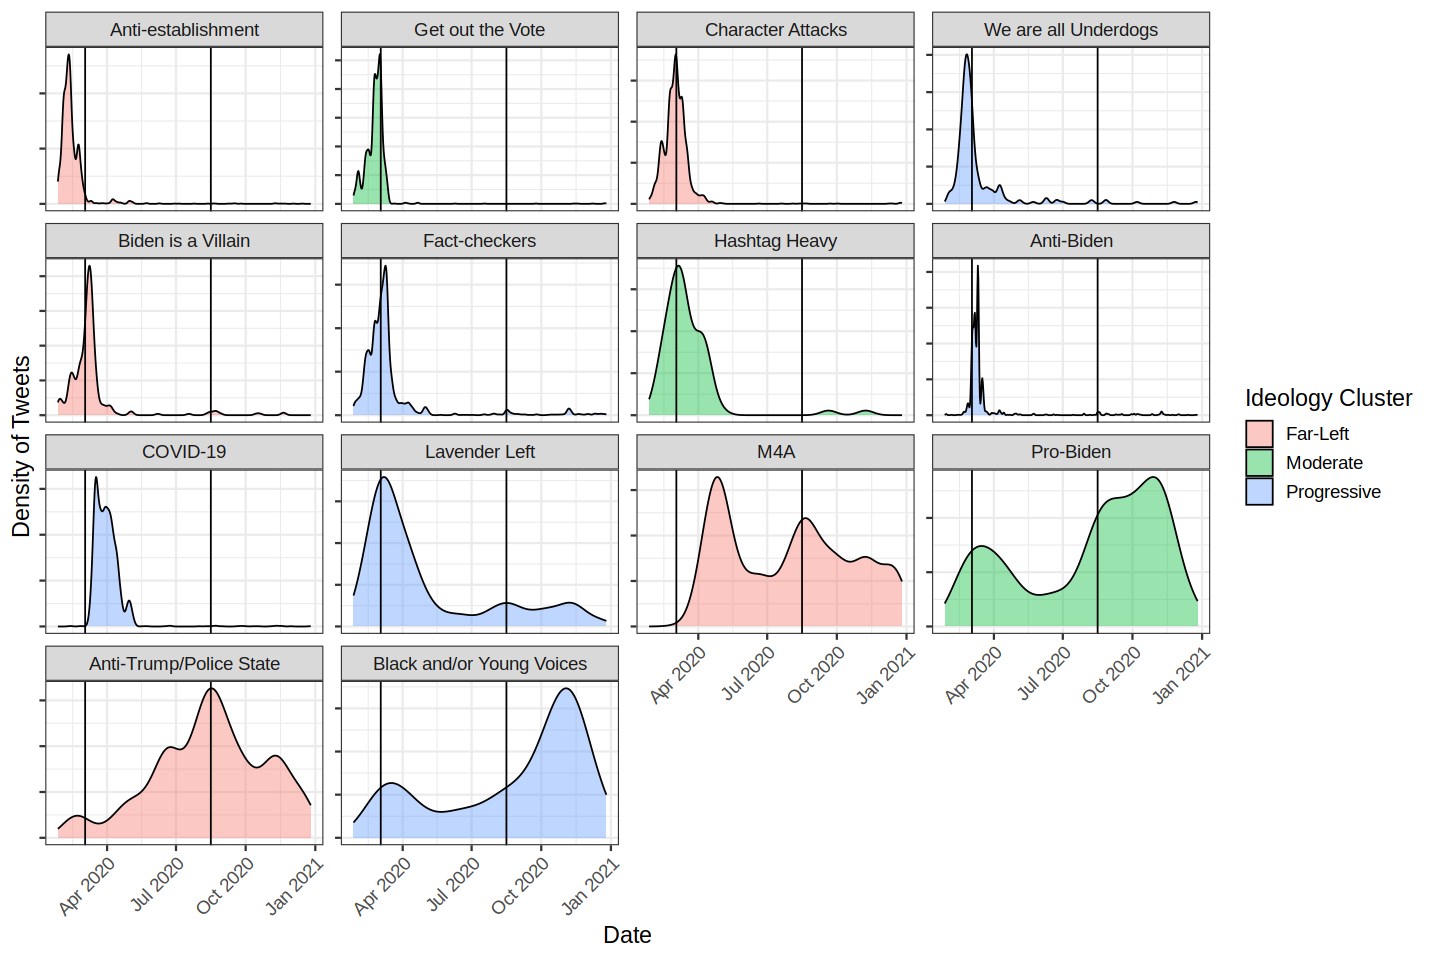

In [15]:

options(repr.plot.width = 12, repr.plot.height = 8)

yres <- yres[grp %in% which(table(bernie_reslist[[20]]$zmg$grp) > 1000)]
yres[, dt := as.Date(as_datetime(created_at))]

yres[, grp := factor(grp, levels=yres[, mean(dt),by=grp][order(V1)]$grp)]
yres[, ideol := mapvalues(grp, names(ideology_grp_labels), ideology_grp_labels)]
yres[, name := mapvalues(grp, names(tweet_grp_labels), tweet_grp_labels)]
time_plt <- ggplot(yres, 
       aes(dt,fill=ideol))+
geom_density(alpha=.4)+
facet_wrap(~name,nrow=4,scales="free_y")+
geom_vline(xintercept = ymd("2020-03-03"),color='black') + 
geom_vline(xintercept = ymd("2020-08-16"),color='black')  + 
theme(axis.text.x=element_text(angle=45,hjust=1),
     axis.text.y=element_blank()) + ylab("Density of Tweets") + xlab("Date") + 
scale_fill_discrete("Ideology Cluster") + theme_bw(14) + 
theme(axis.text.x=element_text(angle=45,hjust=1), axis.text.y=element_blank())
ggsave("plots/fig4.jpg", time_plt, dpi=400, h=8,w=12)
time_plt

In [16]:
bernie_grps <- bernie_reslist[[20]]$zmg[grp %in% which(table(bernie_reslist[[20]]$zmg$grp) > 1000)]

In [17]:
bern_to_orig <- merge(bernie_grps[,.(uid,grp)], 
                      reslist[[35]]$zmg[,.(uid,grp)], by="uid")
setnames(bern_to_orig, c("uid","tweetlevel_grp","userlevel_grp"))

In [18]:
bern_to_orig[,.N, by= userlevel_grp]

userlevel_grp,N
<int>,<int>
27,67136
11,45690
3,5485
19,25144
5,69156


# Main Results, Part 3: Look at Identity/Ideology Overlaps

In [19]:
g <- bern_to_orig[,.N,by=.(tweetlevel_grp,userlevel_grp)]

g[, perc_tw := N/sum(N), by=tweetlevel_grp]
g[, perc_u := N/sum(N), by=userlevel_grp]

In [20]:
g = merge(g, bern_to_orig[,list(nmember=.N), by=userlevel_grp], 
          by="userlevel_grp")

g = merge(g, bern_to_orig[,list(ntw=.N), by=tweetlevel_grp], 
          by="tweetlevel_grp")

In [21]:
g <- data.table(g)

tot <- sum(g$N)


In [22]:
g$k <- as.integer64(g$nmember)*as.integer64(g$ntw)/tot/tot

In [23]:
g[, dval := -log(pbinom(N-1, tot,k, lower.tail=F))]

In [24]:
g[, dval := ifelse(is.infinite(dval), 585, dval)]

In [25]:
g[, tweetlevel_grp_name := mapvalues(tweetlevel_grp, names(tweet_grp_labels), tweet_grp_labels)]
g[, userlevel_grp_name := mapvalues(userlevel_grp, names(user_grp_labels), user_grp_labels)]
g[, ideol := mapvalues(tweetlevel_grp, names(ideology_grp_labels), ideology_grp_labels)]
g[, ideol := factor(ideol, levels=c("Moderate","Progressive","Far-Left"))]

In [26]:
g <- g[order(-perc_u)][, cum:=cumsum(perc_u), by=userlevel_grp_name]

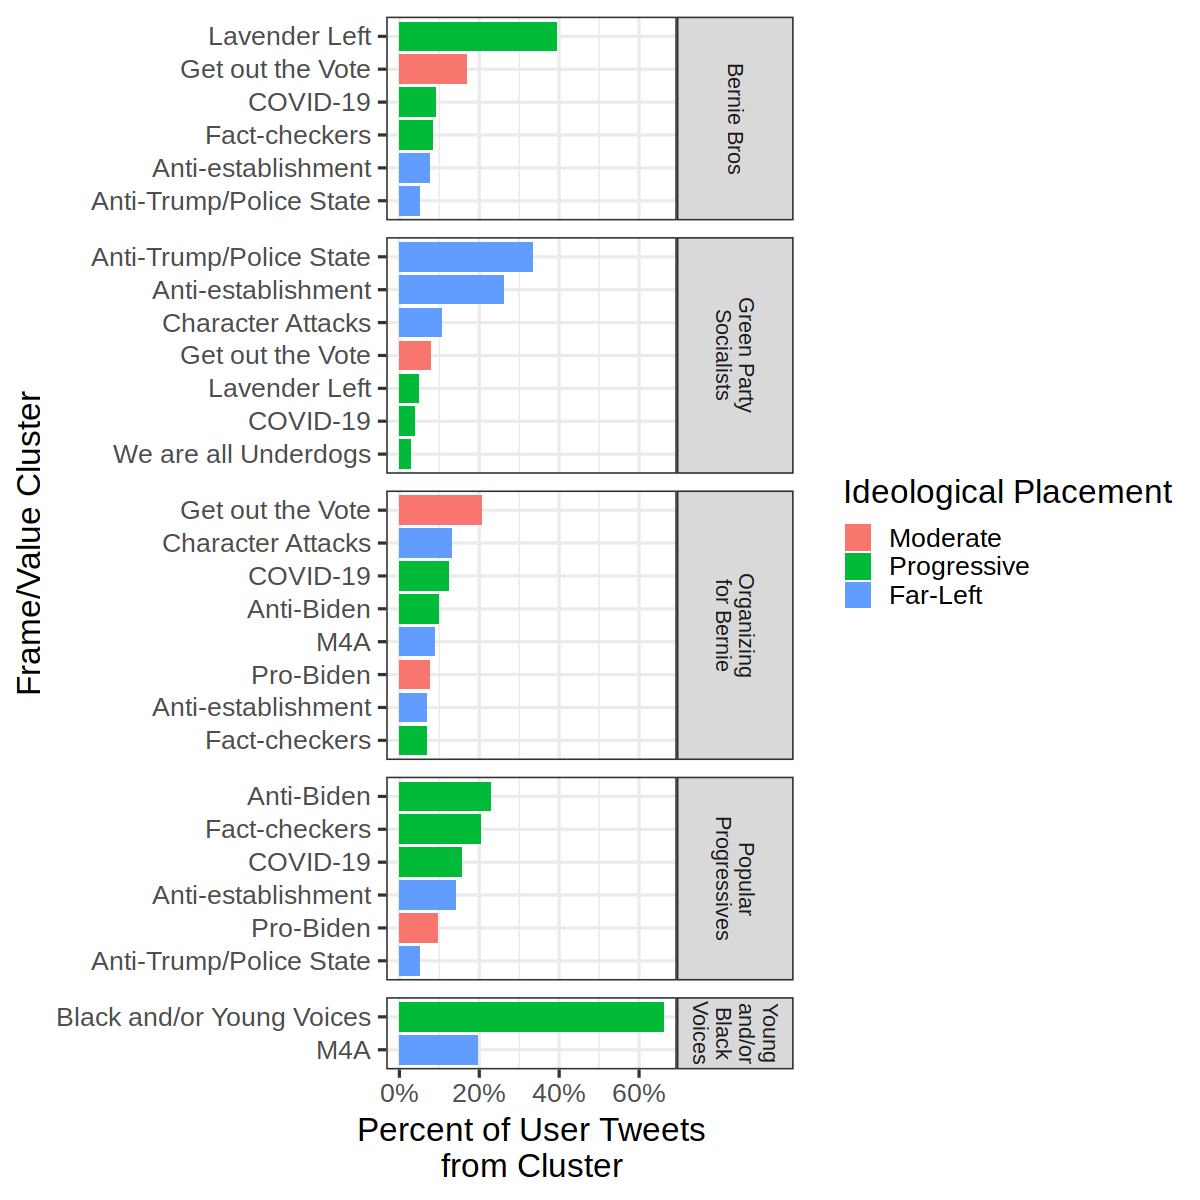

In [27]:
#### Plot
options(repr.plot.width = 10, repr.plot.height = 10)

pl <- ggplot(g[cum <= .9], 
       aes(reorder_within(tweetlevel_grp_name,perc_u,userlevel_grp_name), y=perc_u,
          fill=ideol)) + 
geom_bar(stat='identity') + coord_flip() + scale_x_reordered("Frame/Value Cluster") + 
facet_grid(userlevel_grp_name~.,space="free", scales="free_y") +
scale_y_continuous("Percent of User Tweets\nfrom Cluster",
                   labels=percent)  + 
scale_fill_discrete("Ideological Placement")+                                                                # Change font size
  theme(strip.text.y = element_text(size = 13))
ggsave("plots/fig5.jpg", pl, width=12, height=10)
pl